### set folder_name and day session to analyze

In [6]:
name = 'ANM1'
session = '20240214_d9'

### imports

In [7]:
from scipy import io
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import statistics
import re
import glob
import scipy.signal as signal
import pickle

from common.load_tonedisc_matfile import load_tonedisc_matfile
from common.align_times import get_leverdata_indices
from preprocess_leverdata.get_trial_frequencies import get_trial_frequencies
from preprocess_leverdata.butterworth_filter_leverdata import butterworth_filter_leverdata
from preprocess_leverdata.rescale_leverdata import rescale_leverdata
from preprocess_leverdata.view_processed_trial_FFT import view_processed_trial_FFT
from preprocess_leverdata.calculate_leverdata_sample_times import calculate_leverdata_sample_times

### Setup folders and matfiles

In [8]:
tone_discriminiation_matfile = '../Data_Copy/ToneDiscriminationData/'+name+'/ToneDisc_'+name+'_'+session+'.mat'
params, response, arduino, respMTX, MTXTrialType = load_tonedisc_matfile(tone_discriminiation_matfile)

output_folder = "../Data_Copy/AnalysisData/"+name+"/PreprocessLeverData_"+name+"_"+session+"/"
leverdata_matfile = "../Data_Copy/LeverData/"+name+"/LeverData_"+name+"_"+session+".mat"

respMTX shape: (132, 7)
MTXTrialType shape: (1, 1)
number of trials: 132


In [9]:
open(leverdata_matfile)

FileNotFoundError: [Errno 2] No such file or directory: '../Data_Copy/LeverData/ANM1/LeverData_ANM1_20240214_d9.mat'

For mac:

In [110]:
!mkdir {output_folder}

mkdir: ../Data_Copy/AnalysisData/ANM4/PreprocessLeverData_ANM4_20240213_d1/: File exists


For windows:

In [111]:
!mkdir "{output_folder}"

mkdir: ../Data_Copy/AnalysisData/ANM4/PreprocessLeverData_ANM4_20240213_d1/: File exists


preview trials

In [112]:
respMTX.shape

(59, 7)

In [113]:
respMTX_shape = respMTX.shape[0]
np.set_printoptions(suppress = True,
   formatter = {'float_kind':'{:f}'.format})
print(np.hstack((respMTX[1:respMTX_shape, 1:2]-respMTX[0:respMTX_shape-1, 1:2], np.array([np.linspace(0, respMTX_shape-2, respMTX_shape-1)]).transpose())))

[[7.063785 0.000000]
 [5.326539 1.000000]
 [20.452759 2.000000]
 [26.085240 3.000000]
 [34.840794 4.000000]
 [8.253351 5.000000]
 [6.038934 6.000000]
 [36.784063 7.000000]
 [7.245849 8.000000]
 [6.983772 9.000000]
 [6.014138 10.000000]
 [27.873570 11.000000]
 [9.066830 12.000000]
 [7.363628 13.000000]
 [36.958423 14.000000]
 [19.818578 15.000000]
 [5.937559 16.000000]
 [7.453426 17.000000]
 [35.724327 18.000000]
 [6.497606 19.000000]
 [6.006015 20.000000]
 [36.266686 21.000000]
 [36.050554 22.000000]
 [7.936130 23.000000]
 [5.756002 24.000000]
 [5.991212 25.000000]
 [20.457319 26.000000]
 [7.089535 27.000000]
 [6.905659 28.000000]
 [6.643847 29.000000]
 [12.581020 30.000000]
 [16.287164 31.000000]
 [5.742417 32.000000]
 [16.255459 33.000000]
 [35.848904 34.000000]
 [5.954296 35.000000]
 [6.707542 36.000000]
 [32.139098 37.000000]
 [9.663999 38.000000]
 [7.365010 39.000000]
 [11.182841 40.000000]
 [6.945831 41.000000]
 [8.474034 42.000000]
 [7.169877 43.000000]
 [35.601479 44.000000]
 [

### Run leverdata2binary.cpp to create binary files for each trial from `lever_data` in the LeverData .mat file

In [114]:
!./preprocess_leverdata/leverdata2binary {output_folder} {leverdata_matfile} 30350

leverdata from .mat size: 72000000,72000000
leverdata from .mat rank: 2
leverdata vector size: 72000000
leverdata vector with unused rows taken out size: 5095909
vector saved to .bin file ../Data_Copy/AnalysisData/ANM4/PreprocessLeverData_ANM4_20240213_d1/full.bin
finished a trialITI: 71832 index:0 trialITI length: 41482 samples = ~7s
vector saved to .bin file ../Data_Copy/AnalysisData/ANM4/PreprocessLeverData_ANM4_20240213_d1/trial0.bin
finished a trialITI: 103113 index:1 trialITI length: 31281 samples = ~5s
vector saved to .bin file ../Data_Copy/AnalysisData/ANM4/PreprocessLeverData_ANM4_20240213_d1/trial1.bin
finished a trialITI: 223224 index:2 trialITI length: 120111 samples = ~20s
vector saved to .bin file ../Data_Copy/AnalysisData/ANM4/PreprocessLeverData_ANM4_20240213_d1/trial2.bin
finished a trialITI: 376411 index:3 trialITI length: 153187 samples = ~26s
vector saved to .bin file ../Data_Copy/AnalysisData/ANM4/PreprocessLeverData_ANM4_20240213_d1/trial3.bin
finished a trialITI:

change `num_trials` if seems like `lever_data` stopped before behavior (if total trials detected is less than `num_trials` from `respMTX`)

In [115]:
num_trials = 58

### Look at sampling rates for the `lever_data`

In [116]:
dts, trial_frequencies = get_trial_frequencies(num_trials, respMTX, output_folder)

Trial  0
Duration in MATLAB seconds from respMTX:  7.063784700000001
Number of leverdata samples:  41482
Estimated freq:  5872.489290337515
Trial  1
Duration in MATLAB seconds from respMTX:  5.326538999999999
Number of leverdata samples:  31281
Estimated freq:  5872.668913153552
Trial  2
Duration in MATLAB seconds from respMTX:  20.452758700000004
Number of leverdata samples:  120111
Estimated freq:  5872.606319850631
Trial  3
Duration in MATLAB seconds from respMTX:  26.0852401
Number of leverdata samples:  153187
Estimated freq:  5872.554724922774
Trial  4
Duration in MATLAB seconds from respMTX:  34.8407942


Number of leverdata samples:  204612
Estimated freq:  5872.7708336797905
Trial  5
Duration in MATLAB seconds from respMTX:  8.253350900000001
Number of leverdata samples:  48469
Estimated freq:  5872.64501258513
Trial  6
Duration in MATLAB seconds from respMTX:  6.038933700000001
Number of leverdata samples:  35464
Estimated freq:  5872.559918980398
Trial  7
Duration in MATLAB seconds from respMTX:  36.78406349999999
Number of leverdata samples:  216020
Estimated freq:  5872.6518890442885
Trial  8
Duration in MATLAB seconds from respMTX:  7.245848899999999
Number of leverdata samples:  42552
Estimated freq:  5872.603829759686
Trial  9
Duration in MATLAB seconds from respMTX:  6.983772200000004
Number of leverdata samples:  41013
Estimated freq:  5872.614229885673
Trial  10
Duration in MATLAB seconds from respMTX:  6.0141377000000205
Number of leverdata samples:  35319
Estimated freq:  5872.662343597467
Trial  11
Duration in MATLAB seconds from respMTX:  27.87356989999998
Number of leve

So if estimated frequencies are not all around 5882 Hz, then trials probably aren't aligned. Make sure files are correct, and try increasing the skipped samples in for the C++ trial detection program. Also make sure the statistics are all between 4500 and 5900.

### low pass Butterworth filter `lever_data` with a cutoff frequency of 50 Hz

Assuming electrical noise will be around 60 Hz

In [117]:
cutoff_frequency = 50
butterworth_filter_leverdata(output_folder, num_trials, cutoff_frequency)

### Rescale the filtered_lever_data to 0-5V from 0-1023 analogRead values

In [118]:
rescale_leverdata(output_folder, num_trials)

### Calculate sample time values for each sample based on trial start times

In [119]:
calculate_leverdata_sample_times(output_folder, respMTX, num_trials)

### Get tone and leverpress sample indicies

In [120]:
get_leverdata_indices(output_folder, respMTX, num_trials)

### Check the FFT power spectrum for one of the trials

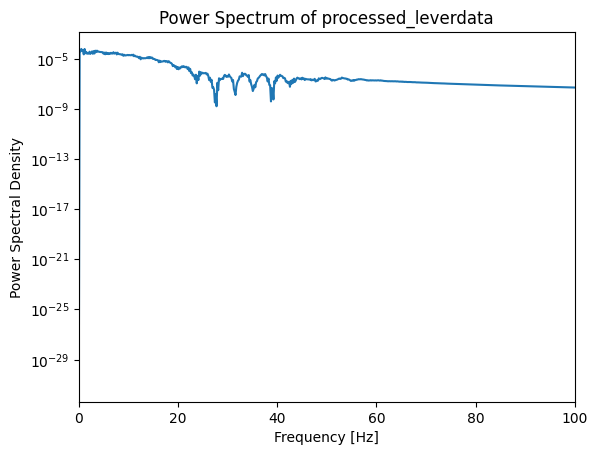

In [121]:
# set which trial to look at
trial_index = 10
view_processed_trial_FFT(trial_index, output_folder)